In [6]:
import pandas as pd
import statsmodels.api as sm
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geoip2.database
import myLogReader as mlr
import re
import os
import sys
import datetime as dt
from pandas.tools.plotting import autocorrelation_plot
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.metrics import mean_absolute_error

%matplotlib inline

## Automate - Read and Prep log data into DF

In [ ]:
logsPath = '../data/logs'
geoLiteIPDBPath = '../data/GeoLite2-City_20181009/GeoLite2-City.mmdb'

#Create a myLogReader object
myLogReader = mlr.log()
#Open Reader
myLogReader.openReader(geoLiteIPDBPath)

In [ ]:
for i in range(1,304):
    print ('AggregatedData_week_%d.csv' % i)
    df =  myLogReader.readLogs(logsPath,7)
    df.to_csv('../data/AggregatedData_week_%d.csv' % i)

In [ ]:
#Close Reader
myLogReader.closeReader()

In [ ]:
df.head()

## 2- Load PlacementSummary and Logs Data aggregated per week

In [7]:
log_aggregated_per_week_df = pd.read_csv('../data/LogsAggregatedData_per_week.csv')
log_aggregated_per_week_df.set_index('calendar-year-week',inplace=True)

In [8]:
log_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count
calendar-year-week,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108
2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818
2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994


In [9]:
placement_summary_df = pd.read_csv('../data/PlacementSummary.csv')
placement_summary_df.set_index('YearWeek',inplace=True)

In [10]:
placement_summary_df.head()

,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
YearWeek,,,,,
2017-50,246,48,234,238,8
2017-51,198,77,196,197,1
2017-52,116,3,115,116,0
2017-53,113,17,96,113,0
2018-01,113,4,111,113,0


In [11]:
log_and_placements_aggregated_per_week_df = log_aggregated_per_week_df.join(placement_summary_df)
log_and_placements_aggregated_per_week_df.head()

,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
calendar-year-week,,,,,,,,,,,,,,,
2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057,246,48,234,238,8
2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453,198,77,196,197,1
2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108,116,3,115,116,0
2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818,113,4,111,113,0
2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994,159,7,159,159,0


In [12]:
log_and_placements_aggregated_per_week_df.isna().sum()

client-ip-unique-count               0
cs-username-unique-count             0
client-connections-count             0
time-taken(ms)-sum                   0
Chrome-count                         0
Firefox-count                        0
Other-count                          0
Safari-count                         0
Desktop-count                        0
Mobile-count                         0
PlacementCount                       0
PlacementCompletedCount              0
PlacementAllocatedInProgressCount    0
PlacementAllocatedCount              0
PlacementNotAllocatedCount           0
dtype: int64

In [13]:
log_and_placements_aggregated_per_week_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 43 entries, 2017-50 to 2018-40
Data columns (total 15 columns):
client-ip-unique-count               43 non-null int64
cs-username-unique-count             43 non-null int64
client-connections-count             43 non-null int64
time-taken(ms)-sum                   43 non-null float64
Chrome-count                         43 non-null int64
Firefox-count                        43 non-null int64
Other-count                          43 non-null int64
Safari-count                         43 non-null int64
Desktop-count                        43 non-null int64
Mobile-count                         43 non-null int64
PlacementCount                       43 non-null int64
PlacementCompletedCount              43 non-null int64
PlacementAllocatedInProgressCount    43 non-null int64
PlacementAllocatedCount              43 non-null int64
PlacementNotAllocatedCount           43 non-null int64
dtypes: float64(1), int64(14)
memory usage: 6.6+ KB


Current size: [20, 7]


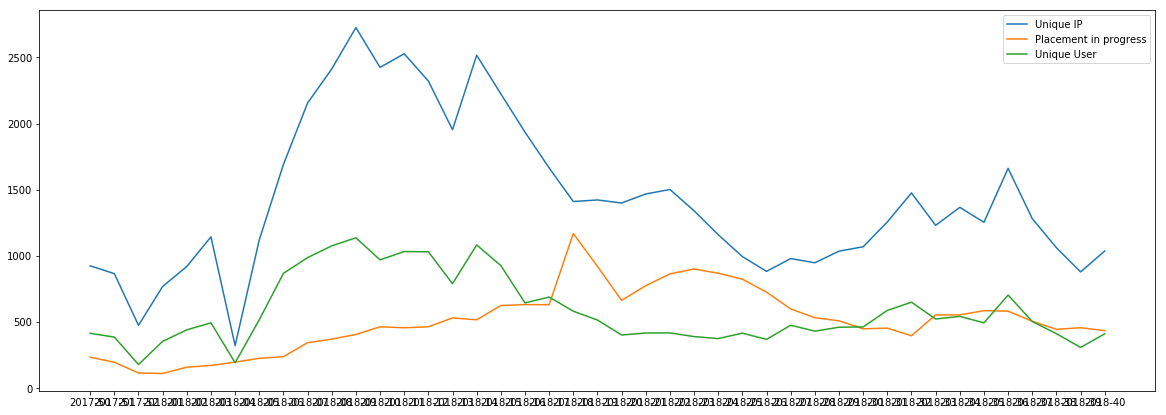

In [14]:
fig_size= plt.rcParams["figure.figsize"]

# Set figure width to 12 and height to 9
fig_size[0] = 20
fig_size[1] = 7
plt.rcParams["figure.figsize"] = fig_size


print ("Current size:",fig_size)

plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-ip-unique-count'],label="Unique IP")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['PlacementAllocatedInProgressCount'],label="Placement in progress")
plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['cs-username-unique-count'],label="Unique User")
plt.legend()

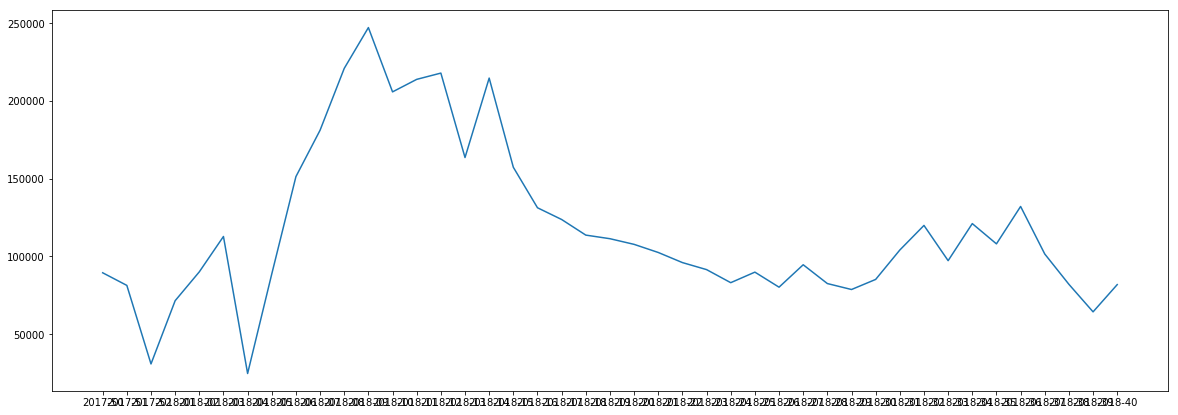

In [15]:

plt.plot(log_and_placements_aggregated_per_week_df.index,log_and_placements_aggregated_per_week_df['client-connections-count'],label="Http Requests Count")

In [16]:
log_and_placements_aggregated_per_week_df.columns

Index(['client-ip-unique-count', 'cs-username-unique-count',
       'client-connections-count', 'time-taken(ms)-sum', 'Chrome-count',
       'Firefox-count', 'Other-count', 'Safari-count', 'Desktop-count',
       'Mobile-count', 'PlacementCount', 'PlacementCompletedCount',
       'PlacementAllocatedInProgressCount', 'PlacementAllocatedCount',
       'PlacementNotAllocatedCount'],
      dtype='object')

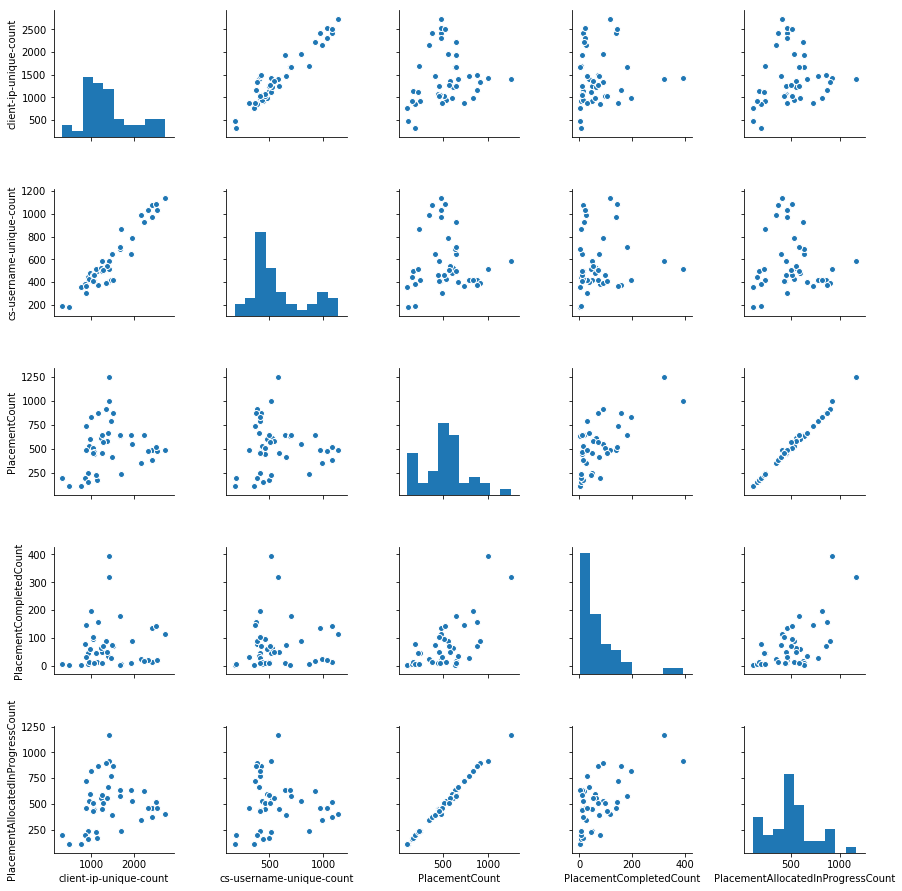

In [17]:
sns.pairplot(data=log_and_placements_aggregated_per_week_df
             ,vars=['client-ip-unique-count','cs-username-unique-count',
                    'PlacementCount', 'PlacementCompletedCount',
                    'PlacementAllocatedInProgressCount'])

In [18]:
log_and_placements_aggregated_per_week_df.reset_index(inplace=True)
log_and_placements_aggregated_per_week_df.head()

,calendar-year-week,client-ip-unique-count,cs-username-unique-count,client-connections-count,time-taken(ms)-sum,Chrome-count,Firefox-count,Other-count,Safari-count,Desktop-count,Mobile-count,PlacementCount,PlacementCompletedCount,PlacementAllocatedInProgressCount,PlacementAllocatedCount,PlacementNotAllocatedCount
0,2017-50,925,415,89497,52520170.0,38500,7784,27741,15472,80440,9057,246,48,234,238,8
1,2017-51,866,386,81378,44703569.0,39664,6585,21274,13855,72925,8453,198,77,196,197,1
2,2017-52,475,179,30843,14199684.0,9978,553,14279,6033,27735,3108,116,3,115,116,0
3,2018-01,769,354,71528,42663674.0,31666,8049,19512,12301,64710,6818,113,4,111,113,0
4,2018-02,920,441,90093,63904084.0,38238,6166,23249,22440,79099,10994,159,7,159,159,0


In [19]:
df_train = log_and_placements_aggregated_per_week_df.loc[:39,['client-connections-count']]
df_test= log_and_placements_aggregated_per_week_df.loc[40:,['client-connections-count']]

In [20]:
df_test.tail()

,client-connections-count
40,82071
41,64358
42,81886


#### Autocorrelation

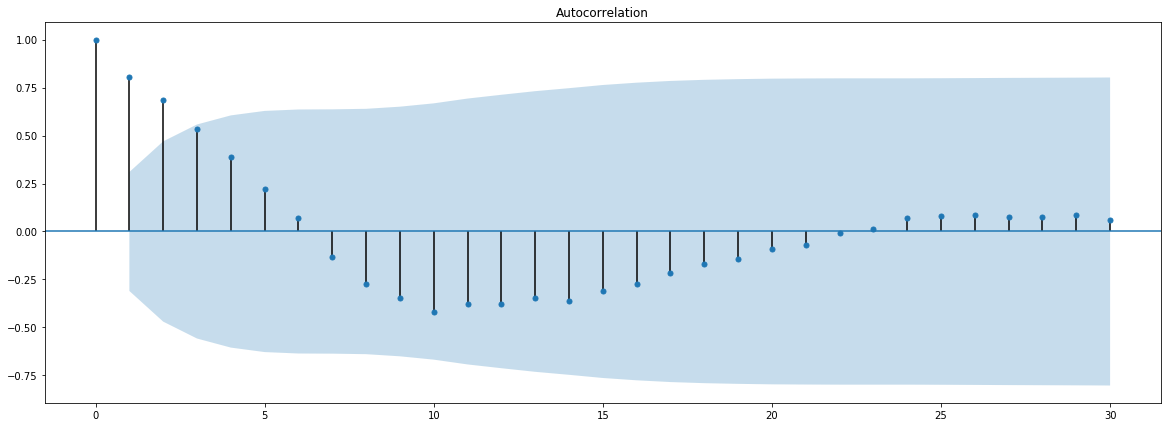

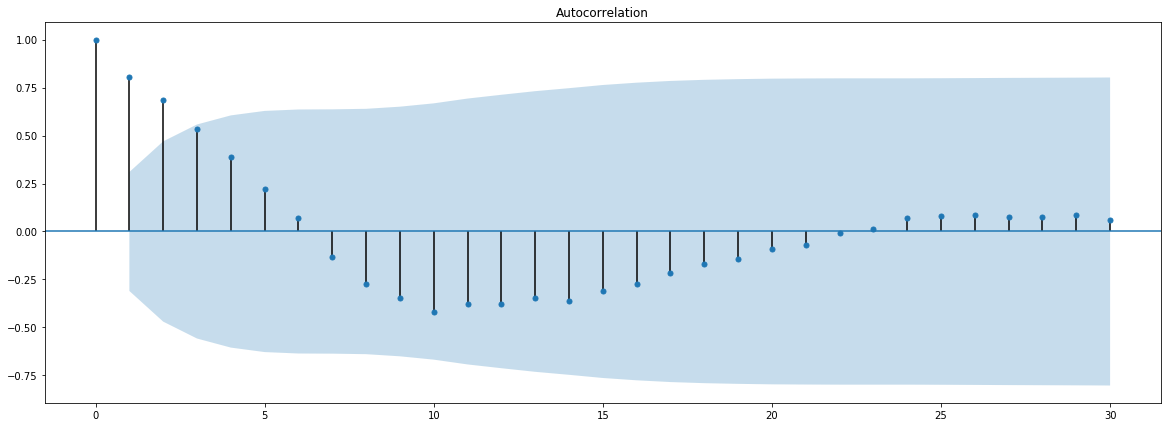

In [21]:
plot_acf(df_train,lags=30)

In [22]:
model = sm.tsa.ARIMA(df_train,(1,0,0)).fit()

predictions = model.predict(40,42,dynamic=True)

predictions

40    105440.890569
41    108512.556752
42    110958.862388
dtype: float64

In [23]:
print("Mean absolute error: ", mean_absolute_error(df_test, predictions))
model.summary()

Mean absolute error:  32199.103236466453


<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ARMA Model Results                                 
====================================================================================
Dep. Variable:     client-connections-count   No. Observations:                   40
Model:                           ARMA(1, 0)   Log Likelihood                -469.722
Method:                             css-mle   S.D. of innovations          30077.359
Date:                      Mon, 12 Nov 2018   AIC                            945.443
Time:                              22:52:10   BIC                            950.510
Sample:                                   0   HQIC                           947.275
                                                                                    
==================================================================================================
                                     coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const                           1.205e+05   2.14e+04      5.626      0.000    7.85e+04    1.63e+05
ar.L1.client-connections-count     0.7964      0.089      8.953      0.000       0.622       0.971
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.2556           +0.0000j            1.2556            0.0000
-----------------------------------------------------------------------------
"""

In [24]:
df_test

,client-connections-count
40,82071
41,64358
42,81886


## ARIMA grid search

In [ ]:
import warnings
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
 
# evaluate an ARIMA model for a given order (p,d,q)
def evaluate_arima_model(X, arima_order):
    # prepare training dataset
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
 
# evaluate combinations of p, d and q values for an ARIMA model
def evaluate_models(dataset, p_values, d_values, q_values):
    dataset = dataset.astype('float32')
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.3f' % (order,mse))
                except:
                    continue
    print('Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))
 
# load dataset
p_values = [0, 1, 2, 4, 6, 8, 10]
d_values = range(0, 3)
q_values = range(0, 3)
warnings.filterwarnings("ignore")
evaluate_models(df_train.values, p_values, d_values, q_values)

ARIMA(0, 0, 0) MSE=1047689976.470
ARIMA(0, 0, 1) MSE=617137849.668
ARIMA(0, 0, 2) MSE=392891089.230
ARIMA(0, 1, 0) MSE=293627279.922
ARIMA(0, 1, 1) MSE=252149078.750
ARIMA(0, 1, 2) MSE=247269338.440
ARIMA(0, 2, 0) MSE=845732498.863
ARIMA(1, 0, 0) MSE=267320117.441
ARIMA(1, 0, 1) MSE=242023313.008
ARIMA(1, 0, 2) MSE=233648715.596
ARIMA(1, 1, 0) MSE=247213421.858
ARIMA(1, 1, 1) MSE=247001141.776
ARIMA(1, 2, 0) MSE=362156468.317
ARIMA(2, 0, 0) MSE=249330114.479


In [ ]:
df['client-ip'].describe()